# ngmix validation

Plot size and response matrix elements for ngmix/metacal runs on star profiles.

Run `fitting_sp_v3.py` first.

The `sp_validation` kernel works.

In [14]:
import numpy as np
from astropy.io import ascii
import matplotlib.pylab as plt
from adjustText import adjust_text

from cs_util import plots as csp

In [15]:
# ShapePipe and ngmix interface
keys = ["sp", "ng"]

markers = {"sp": "o", "ng": "s"}
colors = {"sp": "b", "ng": "orange"}
colors2 = {"sp": "g", "ng": "red"}

In [16]:
%pwd

'/home/mkilbing/astro/repositories/github/shapepipe/scripts/python/T_gal_test/psf_0.93'

In [4]:
# Define PSF size in arcsec^2
T_psf = 0.166776        # FWHM = 0.68"
T_psf = 0.311947        # FWHM = 0.93"

sigma_psf = np.sqrt(T_psf / 2)
fwhm_psf = (2 * np.sqrt(2 * np.log(2))) * sigma_psf
fwhm_psf_str = f"{fwhm_psf:.2f}"

print(f"FWHM_PSF = {fwhm_psf_str} arcsec")

# Open ascii file with results from fitting runs.
dat = ascii.read(f"T.txt", format="commented_header")

FWHM_PSF = 0.93 arcsec


In [5]:
# Compute mean and standard deviation of object size for each flux

T_mean = {}
T_std = {}
SNR_mean = {}

for key in keys:
    T_mean[key] = []
    T_std[key] = []
    SNR_mean[key] = []

n_per_flux = -1
fluxes = list(set(dat["Flux"]))
for flux in fluxes:
    idx = np.where(dat["Flux"] == flux)[0]
    if n_per_flux == -1:
        n_per_flux = len(idx)
    
    for key in keys:
        T_mean[key].append(np.mean(dat[f"T_{key}"][idx]))
        T_std[key].append(np.std(dat[f"T_{key}"][idx]))
        SNR_mean[key].append(np.mean(dat[f"SNR_{key}"][idx]))

In [12]:
print(T_mean)

sigma_true = 0.5        # half-light radius in arcsec
T_true = 2 * sigma_true ** 2

{'sp': [0.43771166, 0.39747624000000004, 0.38366244, 0.39260849999999997, 0.38777501999999997], 'ng': [0.40906448000000006, 0.3844108599999999, 0.38273950000000007, 0.38997825999999997, 0.38736196]}


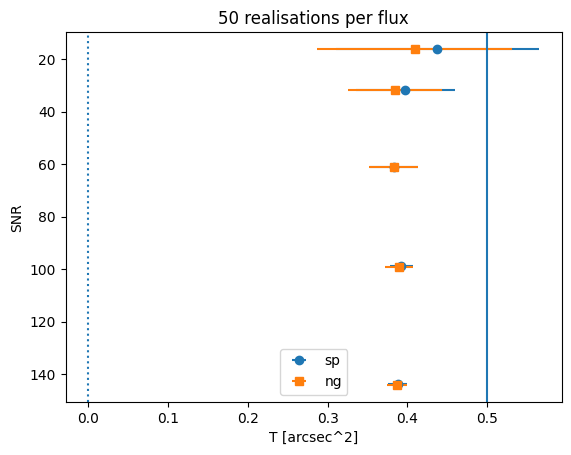

In [13]:
# Plot mean and std

fig, ax = plt.subplots()

for key in keys:
    ax.errorbar(T_mean[key], SNR_mean[key], xerr=T_std[key], fmt=markers[key], label=key)
ax.invert_yaxis()
ax.set_xlabel("T [arcsec^2]")
ax.set_ylabel("SNR")
#ax.set_xlim(-0.005, 0.06)
plt.axvline(x=0, linestyle=":")
plt.axvline(x=T_true)
plt.title(f"{n_per_flux} realisations per flux")
ax.legend()
plt.savefig(f"T_dT.png")

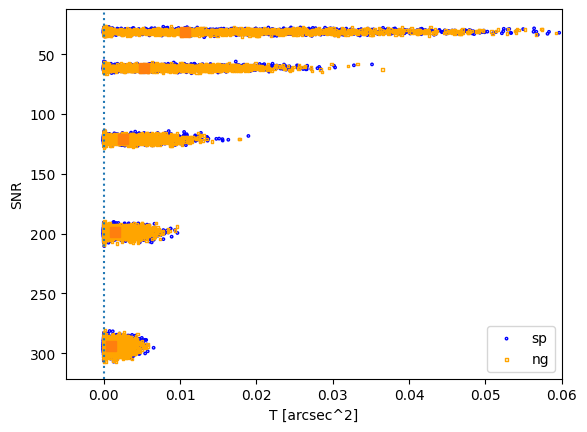

In [8]:
# Plot all measured sizes and mean

fig, ax = plt.subplots()
for key in keys:
    ax.scatter(dat[f"T_{key}"], dat[f"SNR_{key}"], label=key, marker=markers[key], edgecolors=colors[key], facecolor="none", s=3)
    ax.scatter(T_mean[key], SNR_mean[key], marker=markers[key], s=50)

ax.invert_yaxis()
ax.set_xlabel("T [arcsec^2]")
ax.set_ylabel("SNR")
ax.set_xlim(-0.005, 0.06)
plt.axvline(x=0, linestyle=":")
ax.legend()
plt.savefig(f"T.png")

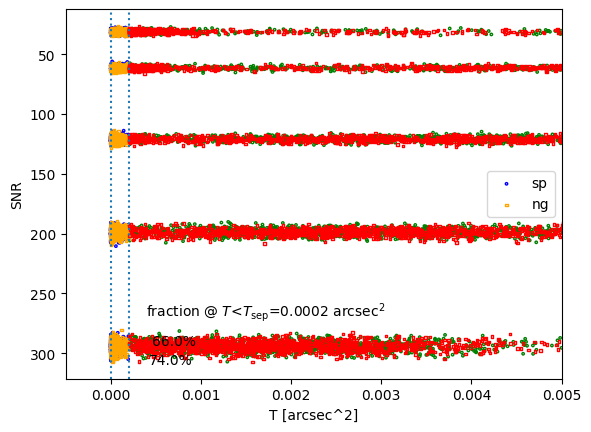

In [9]:
# Separate into two branches, with sizes at or close to 0 and larger.

T_sep = 0.0002
w0 = {}
w1 = {}
num0 = {}
num1 = {}

fig, ax = plt.subplots()

for key in keys:
    w0[key] = dat[f"T_{key}"] < T_sep
    ax.scatter(
        dat[f"T_{key}"][w0[key]],
        dat[f"SNR_{key}"][w0[key]],
        label=key,
        marker=markers[key],
        edgecolors=colors[key],
        facecolor="none",
        s=3
    )
    num0[key] = np.sum(w0[key])

    w1[key] = dat[f"T_{key}"] >= T_sep
    ax.scatter(
        dat[f"T_{key}"][w1[key]],
        dat[f"SNR_{key}"][w1[key]],
        marker=markers[key],
        edgecolors=colors2[key],
        facecolor="none",
        s=3
    )
    num1[key] = np.sum(w1[key])

ax.invert_yaxis()
ax.set_xlabel("T [arcsec^2]")
ax.set_ylabel("SNR")
ax.set_xlim(-0.0005, 0.005)
plt.axvline(x=0, linestyle=":")
plt.axvline(x=T_sep, linestyle=":")
ax.legend()
plt.savefig(f"T_{fwhm_psf_str}_sep.png")

texts = [
    ax.text(
        2 * T_sep,
    SNR_mean[keys[0]][-1] - 10,
    rf"fraction @ $T$<$T_{{\rm sep}}$={T_sep} arcsec$^2$"
       
    )
]
for idx, key in enumerate(keys):
    idxmid = len(SNR_mean[key]) // 2
    texts.append(
       ax.text(
           2 * T_sep,
           SNR_mean[keys[0]][-1] + idx * 10,
            f"{num0[key] / num1[key]:.1%}"
        )
    )

_ = adjust_text(
    texts,
    only_move={'points':'y', 'text':'xy'},
)

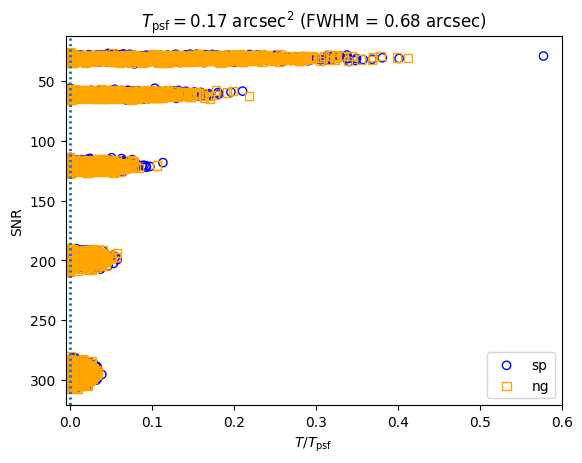

In [10]:
# Plot relative size normalized by PSF

fig, ax = plt.subplots()
for key in keys:
    ax.scatter(dat[f"T_{key}"] / T_psf, dat[f"SNR_{key}"], label=key, marker=markers[key], edgecolors=colors[key], facecolor="none")
ax.invert_yaxis()
ax.set_xlabel("$T/T_{\\rm psf}$")
ax.set_ylabel("SNR")
ax.set_xlim(-0.005, 0.6)
ax.set_title(f"$T_{{\\rm psf}} = {T_psf:.2f}$ arcsec$^2$ (FWHM = ${fwhm_psf_str}$ arcsec)")
plt.axvline(x=0, linestyle=":")
plt.axvline(x=T_sep / T_psf, linestyle=":")
ax.legend()
plt.savefig(f"T_Tpsf.png")

sp 1.7320508075688774 -0.02135232893581431 0.015776275593995526
ng 1.7320508075688774 -0.01104051008660784 0.00027476498252153314
sp 3.464101615137755 0.0001241160880918737 0.0011087787125567752
ng 3.464101615137755 -0.006969411396141137 0.02887543632743711
sp 6.92820323027551 0.008073085817805772 0.016126191202363305
ng 6.92820323027551 0.027854869934387686 -0.006835443104083461
sp 11.547005383792516 -0.0498989401913355 -0.0550017673503116
ng 11.547005383792516 0.01712012955209109 -0.04761979748987982
sp 17.320508075688775 0.050651782248158916 0.0623583875100816
ng 17.320508075688775 -0.07275768294422312 -0.08238178415849763


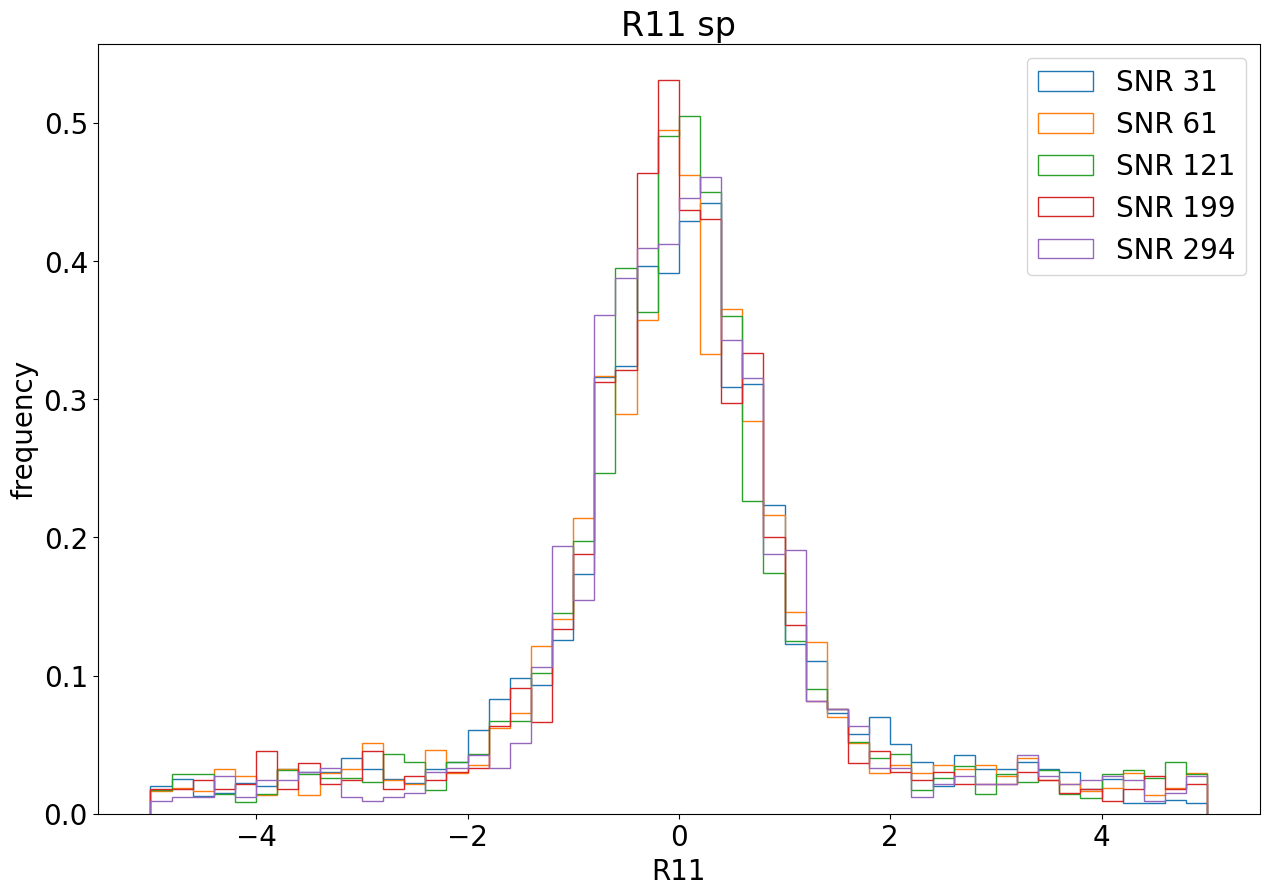

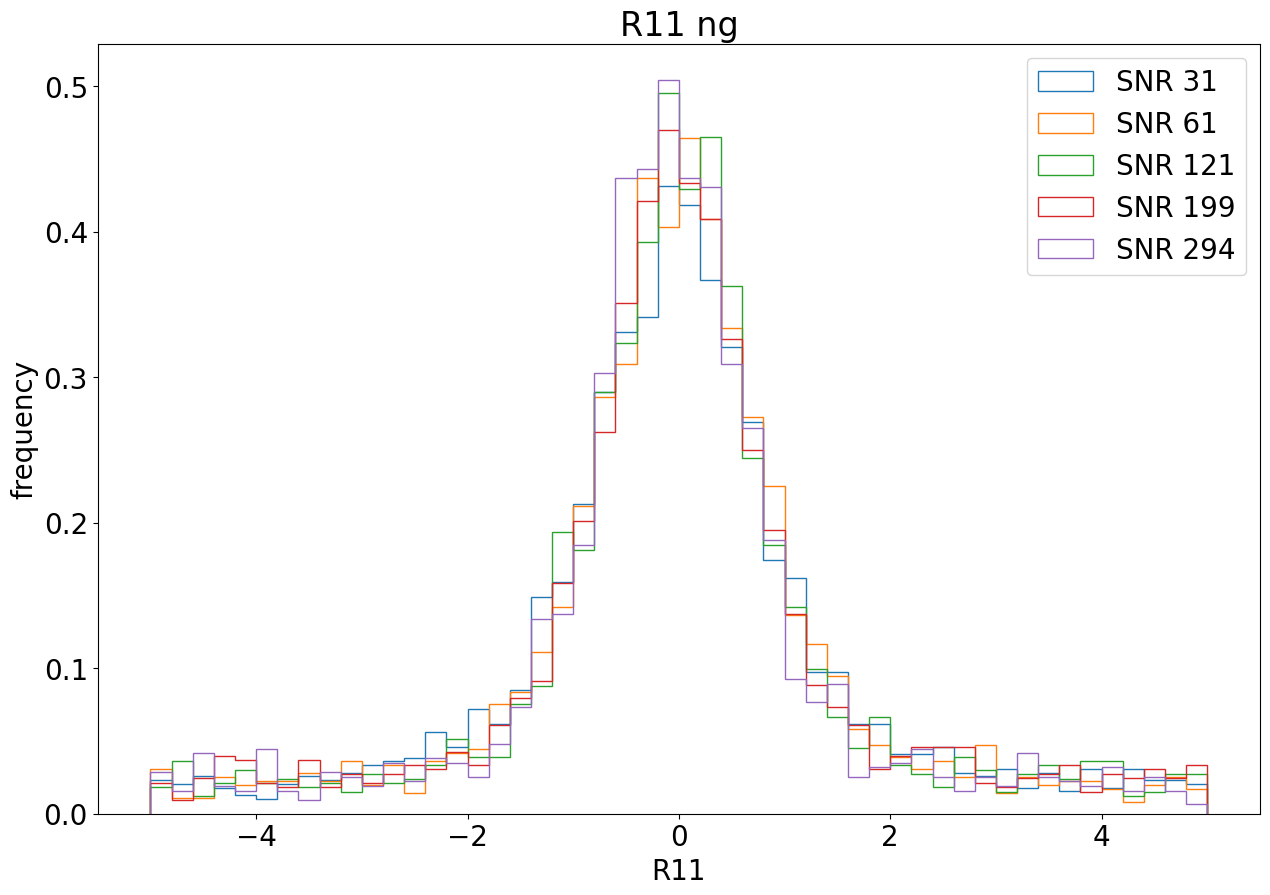

In [13]:
# Response matrix

plt.rcParams.update({'font.size': 20})

# Cut on |R_ii| for plot and computation of mean
R_cut = 5

R11 = {}
for key in keys:
    R11[key] = []

labels = []

fluxes = list(set(dat["Flux"]))
for idx, flux in enumerate(fluxes):
    labels.append(f"SNR {SNR_mean[key][idx]:.0f}")
    idx = np.where(dat["Flux"] == flux)[0]
    for key in keys:
        r = dat[f"R11_{key}"][idx]
        r_cut = r[np.abs(r) < R_cut]
        print(key, flux, np.mean(r_cut), np.median(r))
        R11[key].append(r)

x_label = "R11"
y_label = "frequency"
x_range = [-R_cut, R_cut]
n_bin = 50

for key in keys:
    title = fr"R11 {key}"
    out_path = f"hist_R11_{key}.png"

    _ = csp.plot_histograms(
        R11[key],
        labels,
        title,
        x_label,
        y_label,
        x_range,
        n_bin,
        close_fig=False,
        out_path=out_path,
    )

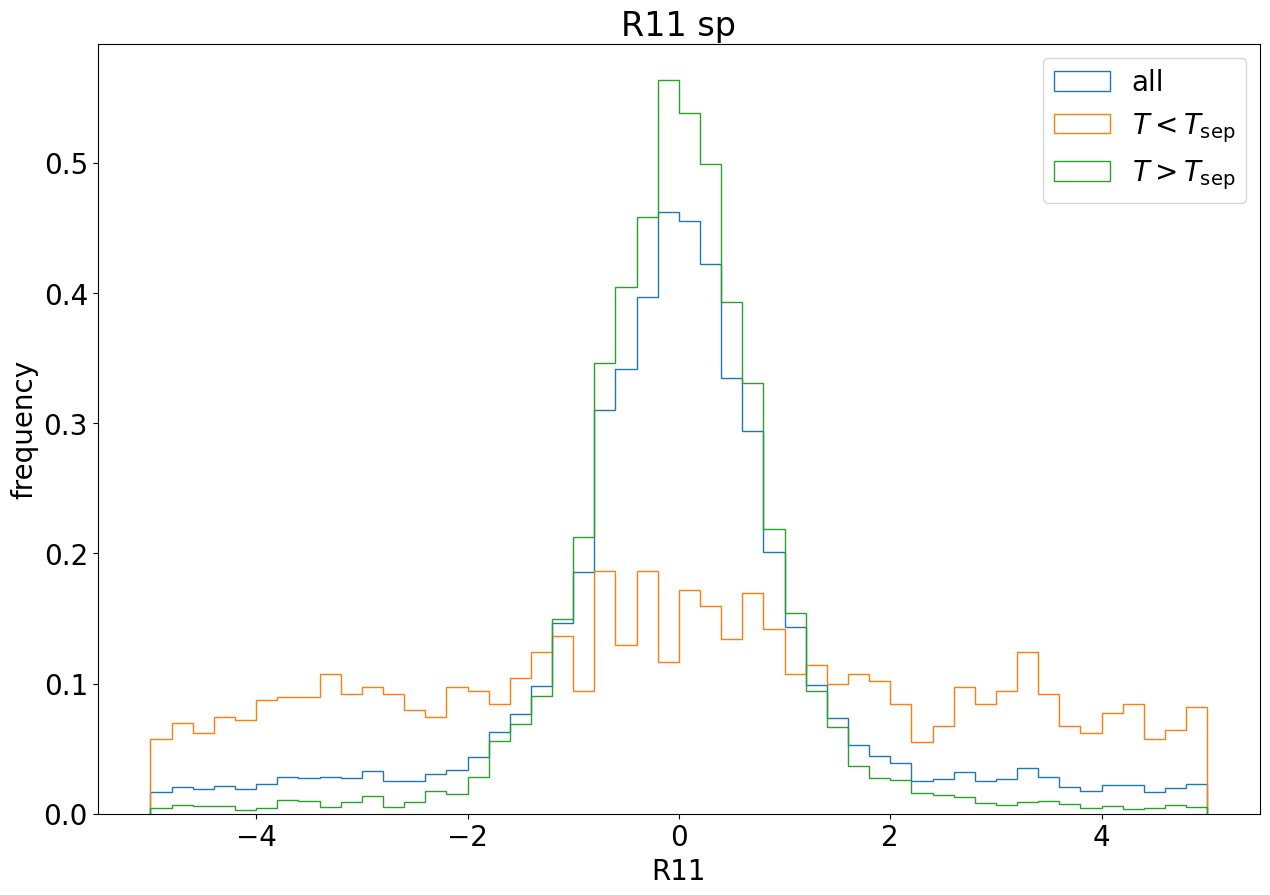

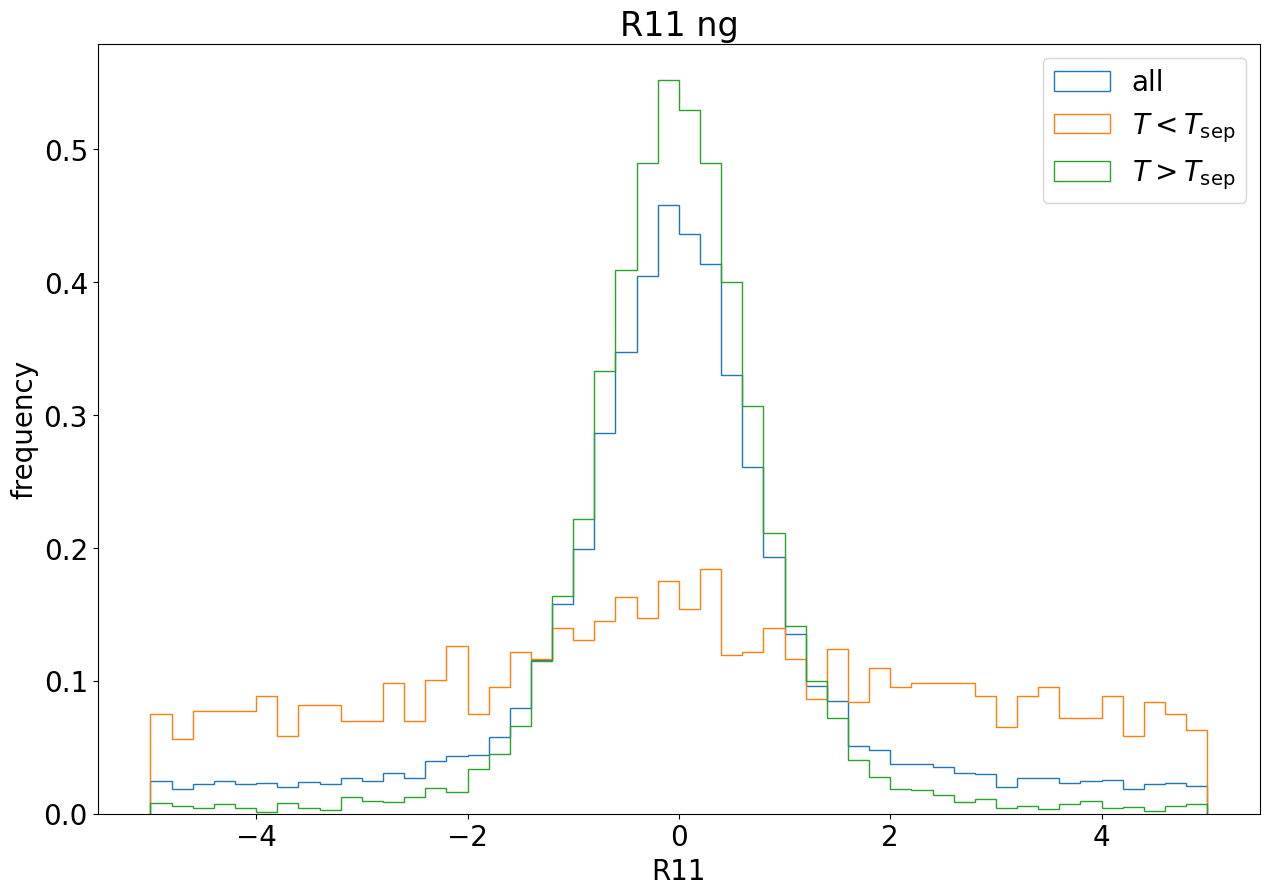

In [14]:
R11 = {}
for key in keys:
    R11[key] = []
labels = []

for key in keys:
        r = dat[f"R11_{key}"]
        R11[key].append(r)
        labels.append("all")

        r = dat[f"R11_{key}"][w0[key]]
        R11[key].append(r)
        labels.append(r"$T<T_{\rm sep}$")

        r = dat[f"R11_{key}"][w1[key]]
        R11[key].append(r)
        labels.append(r"$T>T_{\rm sep}$")


x_label = "R11"
y_label = "frequency"
x_range = [-R_cut, R_cut]
n_bin = 50

for key in keys:
    title = fr"R11 {key}"
    out_path = f"hist_R11_{key}_Tsep.png"

    _ = csp.plot_histograms(
        R11[key],
        labels,
        title,
        x_label,
        y_label,
        x_range,
        n_bin,
        close_fig=False,
        out_path=out_path,
    )